# Data Access
## Goals
* Goal of the notebook is to download the mnist data,split the data for training and testing as required and finally augment the data. 


## Import Libraries

In [2]:
from pathlib import Path
from sklearn.datasets import fetch_openml
import pandas as pd

## Set Constants

In [3]:
data_dir = Path("..","data")
models_dir = Path("..","models")

## Access MNIST Dataset

In [4]:
mnist = fetch_openml("mnist_784", as_frame=True)

In [5]:
mnist["data"]

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
mnist["target"]

0        5
1        0
2        4
3        1
4        9
        ..
69995    2
69996    3
69997    4
69998    5
69999    6
Name: class, Length: 70000, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

In [7]:
raw_mnist_data = pd.concat([mnist["data"],mnist["target"]],axis=1)
raw_mnist_data.head()   

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


In [8]:
raw_mnist_data.shape

(70000, 785)

In [9]:
raw_mnist_data.dtypes.unique()

array([dtype('int64'),
       CategoricalDtype(categories=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], ordered=False, categories_dtype=object)],
      dtype=object)

In [10]:
## update class datatype to int64
raw_mnist_data["class"] = raw_mnist_data["class"].astype("int64")
raw_mnist_data.dtypes.unique()

array([dtype('int64')], dtype=object)

In [11]:
## save the raw data to data dir
raw_mnist_data.to_csv(Path(data_dir,"raw_mnist_data.csv"),index=False)

## Train / Test Split

In [12]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

In [13]:
for train_idx, test_idx in splitter.split(raw_mnist_data,raw_mnist_data["class"]):
    mnist_dev_set = raw_mnist_data.iloc[train_idx].reset_index(drop=True)
    mnist_test_set = raw_mnist_data.iloc[test_idx].reset_index(drop=True)

In [14]:
mnist_dev_set.shape,mnist_test_set.shape

((63000, 785), (7000, 785))

## Train / Validation Split

In [15]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_idx, val_idx in splitter.split(mnist_dev_set,mnist_dev_set["class"]):
    mnist_train_set = mnist_dev_set.iloc[train_idx].reset_index(drop=True)
    mnist_val_set = mnist_dev_set.iloc[val_idx].reset_index(drop=True)

In [16]:
mnist_train_set.shape, mnist_val_set.shape

((56700, 785), (6300, 785))

## Save Split Data

In [17]:
mnist_train_set.to_csv(Path(data_dir,"train_set.csv"),index=False)
mnist_val_set.to_csv(Path(data_dir,"val_set.csv"),index=False)
mnist_test_set.to_csv(Path(data_dir,"test_set.csv"),index=False)

## Augmenting Data

* We'll be using `TensorFlow` data augmentation APIs to augment the data during training. 
* In this section we'll simply explore the APIs to understand and finalize which augmentation techniques should we use. 
* For now we'll focus on `RandomTranslation` for image shifting, `RandomZoom` for zooms and `RandomRotation` to slightly rotating the images. 

In [18]:
mnist_train_set.shape

(56700, 785)

In [19]:
## lets take a sample record for each class
samples = pd.DataFrame({})
for class_val in range(10):
    samples = pd.concat([mnist_train_set[mnist_train_set["class"] == class_val].sample(1),samples], axis=0)

samples = samples.sort_values(by=["class"],ascending=True)
samples = samples.drop(columns=["class"])
samples.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
44563,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8335,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44223,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20390,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48251,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
import matplotlib.pyplot as plt


def plot_numbers(image_df):
    ## lets render each image to do a quick visual inspection
    fig,axs = plt.subplots(2,5,figsize=(10,3))
    axs = axs.ravel()
    for idx in range(0,10,1):
        image_data = image_df.iloc[idx].values.reshape(28, 28)  # MNIST images are 28x28 pixels
        # Render the image using Matplotlib
        axs[idx].imshow(image_data)  # Use 'gray' colormap to render grayscale
        
        
    plt.axis("off") # Remove axes for better visualization    
    plt.show()

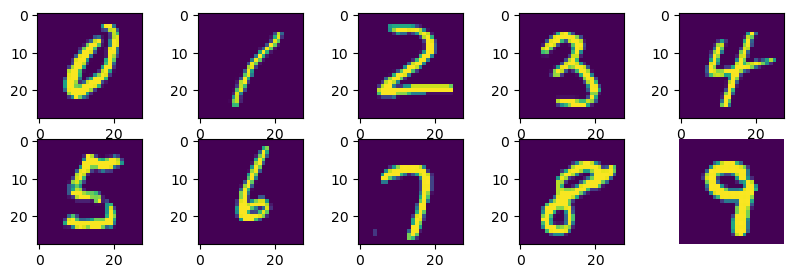

In [21]:
plot_numbers(samples)

### RandomTranslation

In [22]:
import matplotlib.pyplot as plt


def plot_before_after(before_image,after_image):
    ## lets render each image to do a quick visual inspection
    fig,axs = plt.subplots(1,2,figsize=(10,3))
    axs = axs.ravel()
    axs[0].imshow(before_image)
    axs[1].imshow(after_image)        
        
    plt.axis("off") # Remove axes for better visualization    
    plt.show()

In [23]:
import tensorflow as tf

2025-06-29 12:43:49.411745: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-29 12:43:49.421825: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-29 12:43:49.425357: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-29 12:43:49.433999: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [25]:
samples_tensor = tf.convert_to_tensor(samples)
samples_tensor = tf.reshape(samples_tensor,shape=(10,28,28,1))
samples_tensor.shape


TensorShape([10, 28, 28, 1])

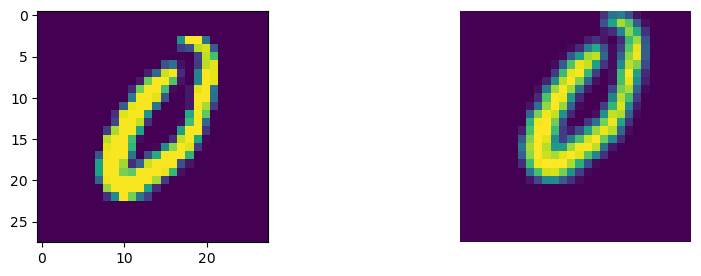

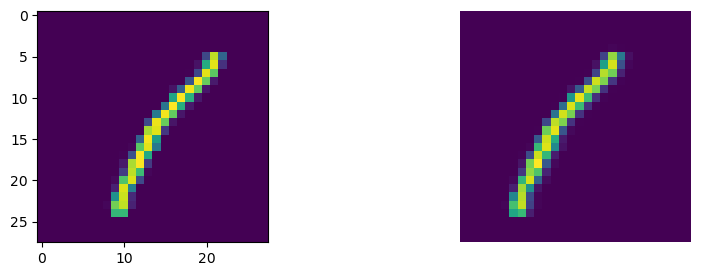

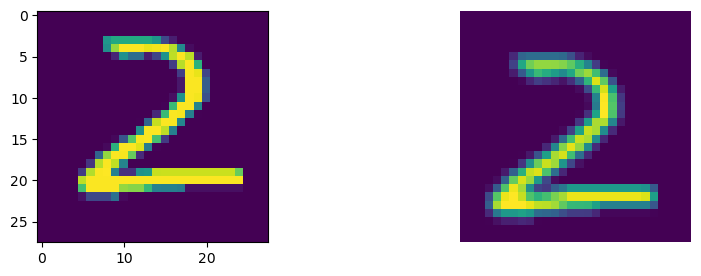

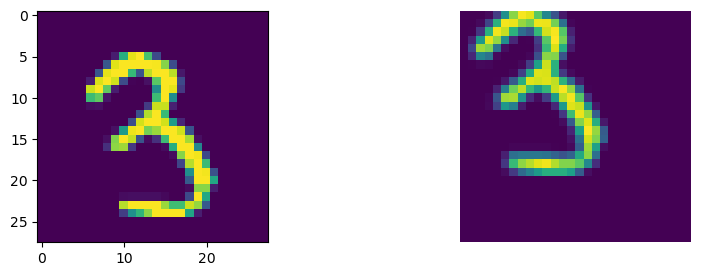

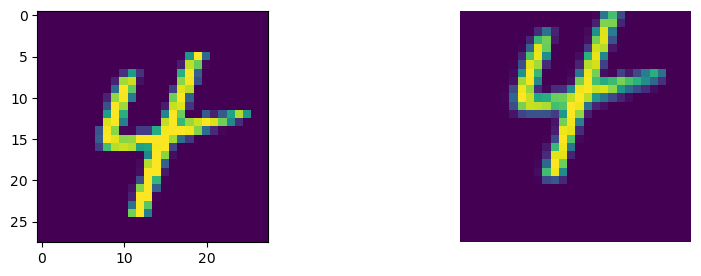

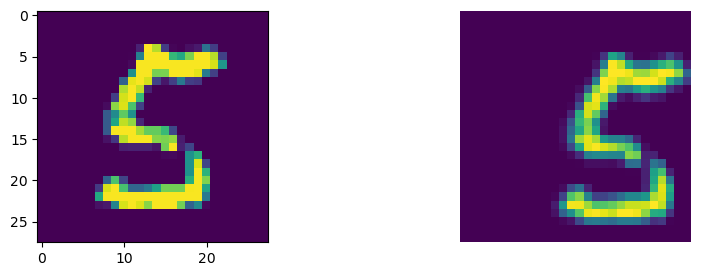

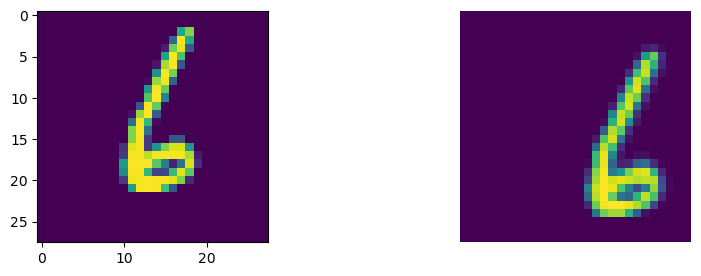

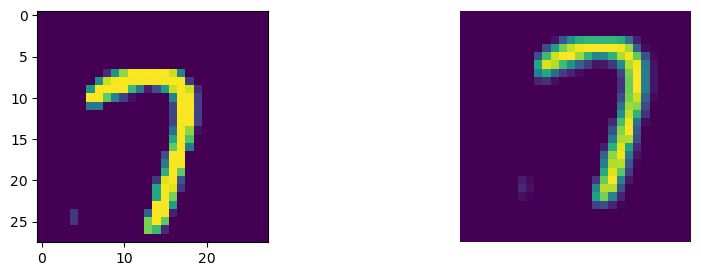

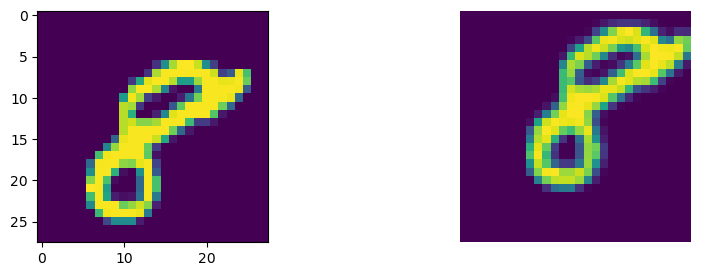

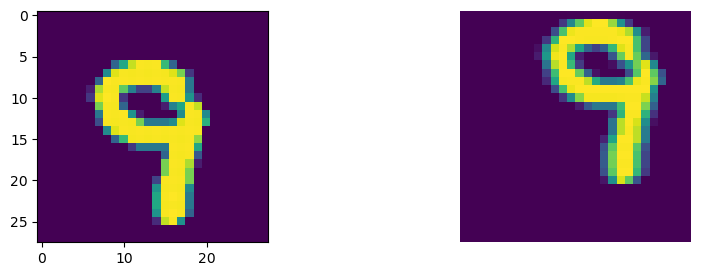

In [29]:
tf_translate = tf.keras.Sequential([
    tf.keras.layers.RandomTranslation(height_factor=0.2,width_factor=0.2,fill_value=0.0,fill_mode="constant",seed=42)
])

result = tf_translate(samples_tensor)

for translated_imgs in range(result.shape[0]):
    plot_before_after(samples.iloc[translated_imgs].values.reshape(28,28),result[translated_imgs])

* So the RandomTranslation works as expected. We see some images randomly shifted up, down, left and right. 

### RandomZoom

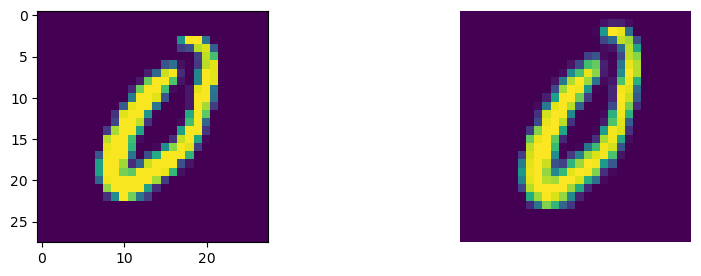

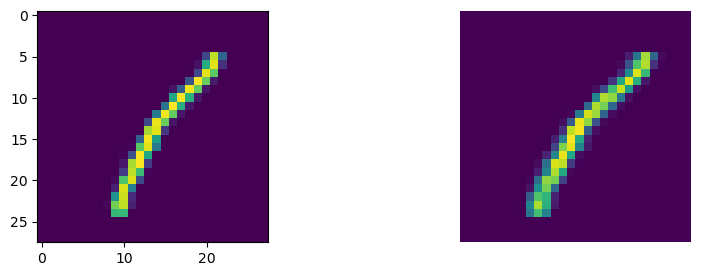

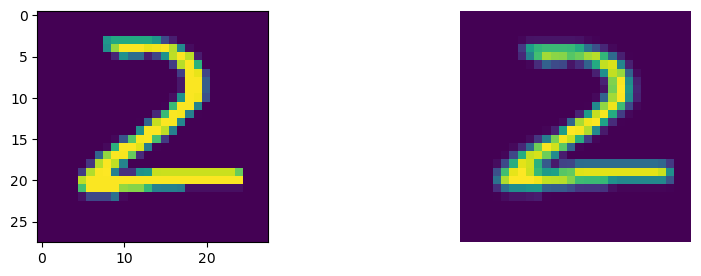

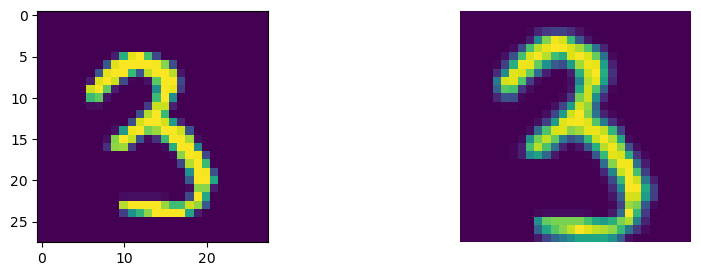

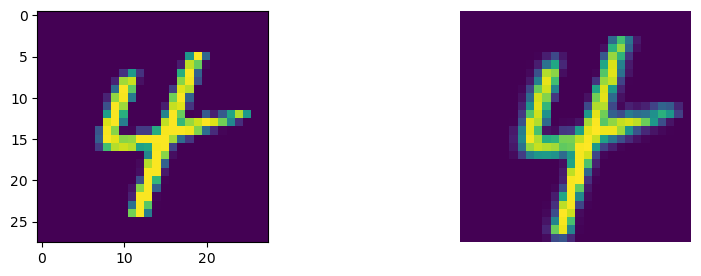

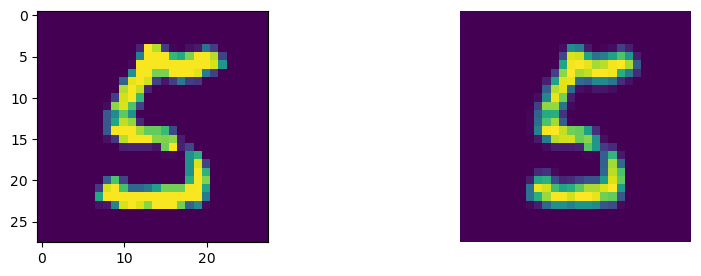

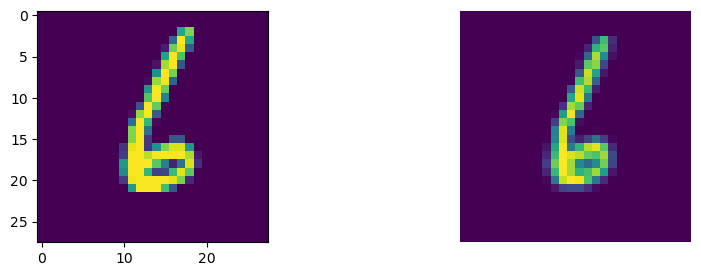

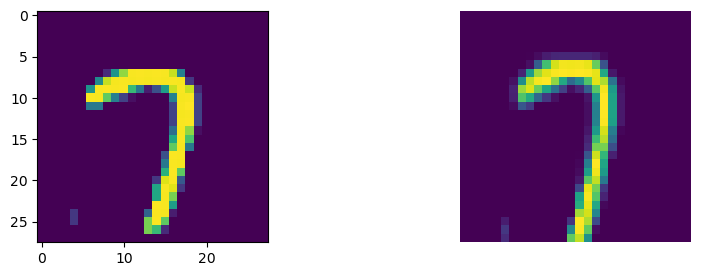

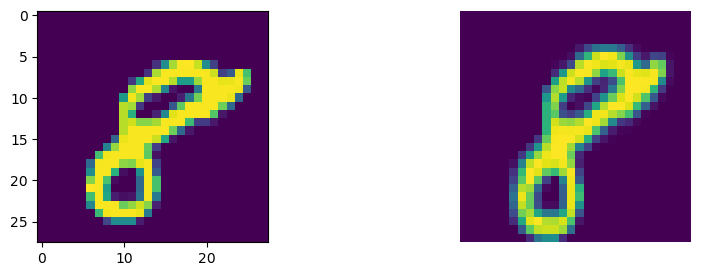

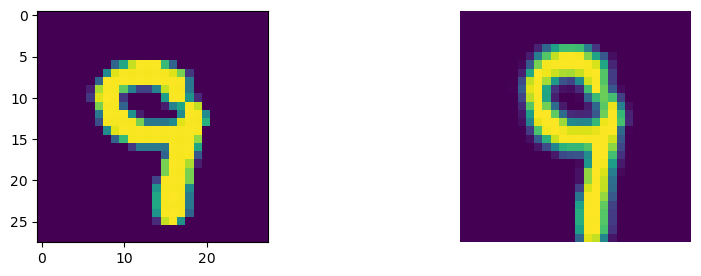

In [30]:
tf_translate = tf.keras.Sequential([
    tf.keras.layers.RandomZoom(height_factor=0.2,width_factor=0.2,fill_value=0.0,fill_mode="constant",seed=42)
])

result = tf_translate(samples_tensor)

for translated_imgs in range(result.shape[0]):
    plot_before_after(samples.iloc[translated_imgs].values.reshape(28,28),result[translated_imgs])

* So the implementation of `RandomZoom` is similar to `RandomTranslate` and rendering the image matches our expectations of how zoom might work.
* From image plots it seems like 0.2 factor for the zoom should work for now. 

### RandomRotation

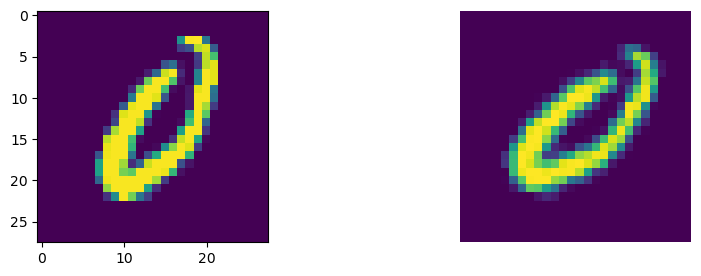

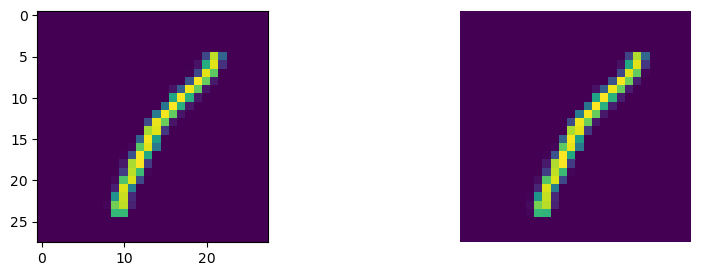

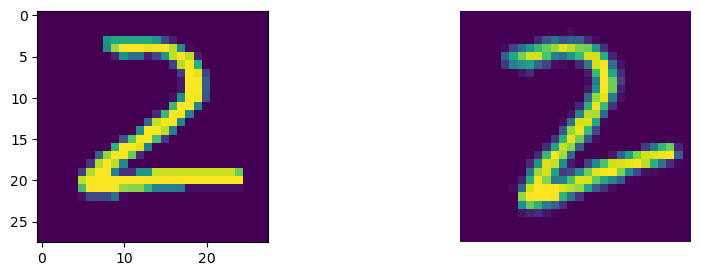

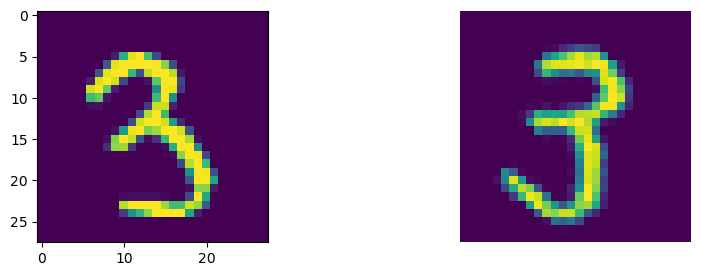

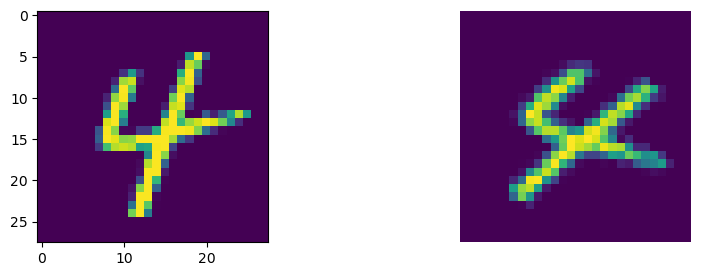

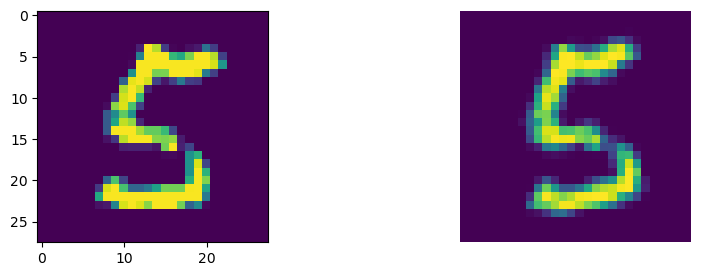

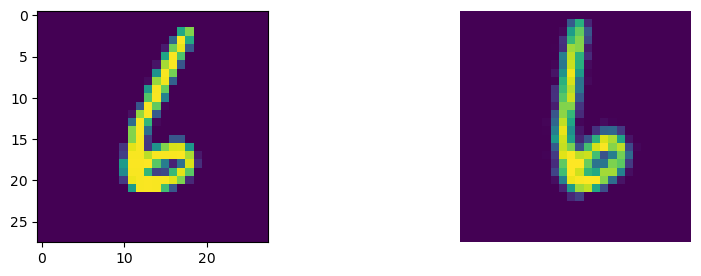

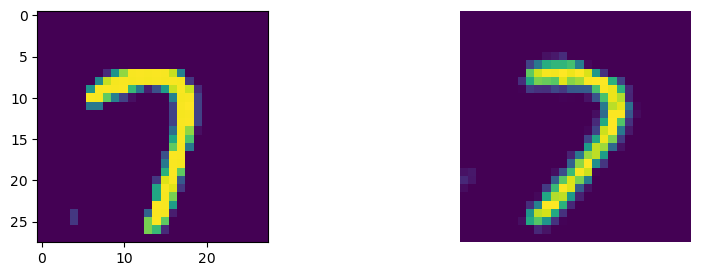

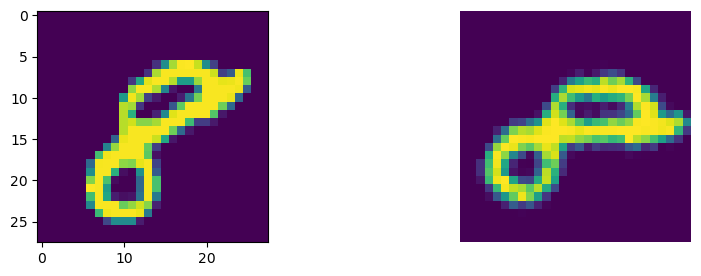

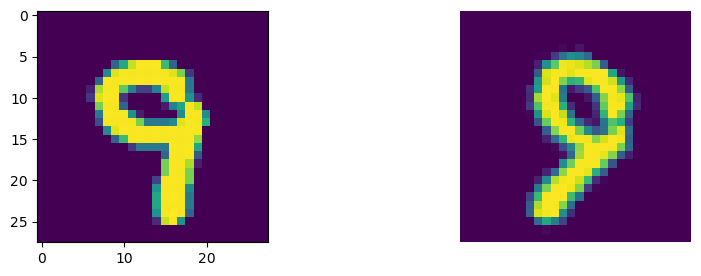

In [32]:
tf_translate = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(factor=0.1,fill_value=0.0,fill_mode="constant",seed=42)
])

result = tf_translate(samples_tensor)

for translated_imgs in range(result.shape[0]):
    plot_before_after(samples.iloc[translated_imgs].values.reshape(28,28),result[translated_imgs])

* So image rotation works as expected, but am not sure how this will help train a better model. 
* Main question is are there cases where we need to recognize slant 8's. 
* We'll include this in training for now and try to understand the effect of this augmentation. 